In [172]:
from matplotlib.backends.backend_pdf import PdfPages


def plot_map(park, trails, roads, output_pdf):
    """
    Plot the GIS data and save it to a PDF.
    """
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the background (roads)
    roads.plot(ax=ax, color='gray', linewidth=0.5)

    # Plot the park boundary
    park.plot(ax=ax, color='lightgreen', edgecolor='green', linewidth=2, label='Park Boundary')

    # Plot the trails
    trails.plot(ax=ax, color='brown', linewidth=1.5, label='Trails')

    # Set the title and labels
    ax.set_title('Park with Trails', fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add a legend
    ax.legend(loc='upper right')

    # Remove axis ticks for better visualization
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

    # Save the plot to the output PDF
    # with PdfPages(output_pdf) as pdf:
    #     pdf.savefig(fig)
    #     plt.close(fig)



In [182]:
import geopandas
from io import BytesIO
import matplotlib.pyplot as plot
import os
import pandas as pd
import re
import urllib

data_directory = './data'
data_library_filename = 'library.csv'

class DataLibrary:
    def __init__ ( self, directory, library_filename ):
        self.directory = directory
        self.library_filename = library_filename

        if not os.path.exists( self.get_library_filename() ):
            self.library = pd.DataFrame()
            self.save_library()

        try:
            self.library = pd.read_csv( self.get_library_filename() )

        except:
            self.library = pd.DataFrame()

    def clear_library ( self ):
        if len( self.library ) == 0:
            return
        
        for filename in self.library._filename:
            os.remove( filename )
            
        self.library = pd.DataFrame()
        self.save_library()

    def get_library_filename ( self ):
        return f'{self.directory}/{self.library_filename}'
    
    def get_next_data_filename ( self ):
        filename = lambda suffix: f'{self.directory}/data-{suffix:05d}'
        suffix = 0

        while os.path.exists( filename( suffix ) ):
            suffix += 1

        return filename( suffix )
    
    def save_data ( self, data, **kwargs ):
        filename = self.get_next_data_filename()
        data.to_file( filename, driver = 'GeoJSON' )
        # with open( filename, 'wb' ) as file:
        #     file.write( data.getbuffer() )

        self.library = pd.concat(
            [
                self.library,
                pd.DataFrame.from_records( [ { **kwargs, '_filename': filename } ] )
            ],
            axis = 0,
            ignore_index = True
        )
        self.save_library()

    def save_library ( self ):
        self.library.to_csv( self.get_library_filename(), index = False )

library = DataLibrary( data_directory, data_library_filename )

In [186]:
build_cache = False

def append_query_to_url ( url, offset = 0 ):
    return f'{url}?where=1%3D1&timeRelation=esriTimeRelationOverlaps&geometryType=esriGeometryEnvelope&spatialRel=esriSpatialRelIntersects&units=esriSRUnit_Foot&returnGeometry=true&returnTrueCurves=false&returnIdsOnly=false&returnCountOnly=false&returnZ=false&returnM=false&returnDistinctValues=false&returnExtentOnly=false&sqlFormat=none&featureEncoding=esriDefault&f=geojson&resultOffset={offset}'

def fetch_geojson ( url, append_query = True ):
    offset = 0
    geo_df = geopandas.GeoDataFrame()
    while True:
        if append_query:
            offset_url = append_query_to_url( url, offset = offset )

        # print( offset_url )

        response = urllib.request.urlopen( offset_url, {} )
        json = response.read()
        request_df = geopandas.read_file( json )
        if not append_query or len( request_df ) == 0:
            return geo_df

        geo_df = pd.concat(
            [
                geo_df,
                request_df
            ],
            axis = 0,
            ignore_index = True
        ).pipe( geopandas.GeoDataFrame )

        offset += len( request_df )

if build_cache:
    library.clear_library()

    # road data (index 0)
    url_road_data = 'https://gisweb.ci.roswell.ga.us/arcgis/rest/services/LGIM_ReferenceData/RoadCenterline/MapServer/0/query'
    # water
    url_water_data = 'https://gisweb.ci.roswell.ga.us/arcgis/rest/services/LGIM_ReferenceData/Waterbody/MapServer/0/query'
    # streams
    url_streams_data = 'https://gisweb.ci.roswell.ga.us/arcgis/rest/services/LGIM_ReferenceData/Streams_110603_/MapServer/0/query'

    urls = {
        'road': url_road_data,
        'water': url_water_data,
        'streams': url_streams_data
    }

    for label, url in urls.items():
        geojson = fetch_geojson( url )

        if len( geojson ) > 0:
            library.save_data( geojson, label = label )

        else:
            print( f'> No data returned for {label}' )

    # build the park layers
    park_data_directory_url = 'https://gisweb.ci.roswell.ga.us/arcgis/rest/services/LGIM_Parks/Park_Facilities/MapServer'
    response = urllib.request.urlopen( park_data_directory_url )
    park_data_directory_html = response.read()
    park_data_layers = re.findall( r'\/(\d+)">([^<]+)<\/a', park_data_directory_html.decode() )

    for ix, label in park_data_layers:
        park_layer_url = f'https://gisweb.ci.roswell.ga.us/arcgis/rest/services/LGIM_Parks/Park_Facilities/MapServer/{ix}/query'
        geojson = fetch_geojson( park_layer_url )

        if len( geojson ) > 0:
            library.save_data( geojson, label = 'park', layer = label, ix = ix )

        else:
            print( f'> No data returned for {label}' )


> No data returned for Memorial Plaque


In [235]:
#
# Start by loading all parks data
#
def get_geodf ( label, layer = None ):
    df = library.library[lambda _df: _df.label == label]
    if layer is not None:
        df = df[df.layer == layer]

    if len( df ) > 1:
        raise Exception( f'Selector label={label}, layer={layer} is nonunique.' )

    return geopandas.read_file( df.iloc[0]._filename )

park_bounds = get_geodf( 'park', 'RoswellParks' )
# park_bounds = geopandas.read_file( park_bounds ).set_crs( 'EPSG:2240', allow_override = True )

def find_park ( park_name, park_data = park_bounds ):
    return [ name for name in park_data.Name if re.search( park_name, name ) ]

def expand_clip_box ( clip_box, expand = 5e-4 ):
    return [
        clip_box[0] - expand,
        clip_box[1] - expand,
        clip_box[2] + expand,
        clip_box[3] + expand
    ]

print( find_park( 'East' ) )
target = 'Don White Memorial Park'
# target = 'Riverside Park'
target = 'East Roswell Park'

['East Roswell Park']


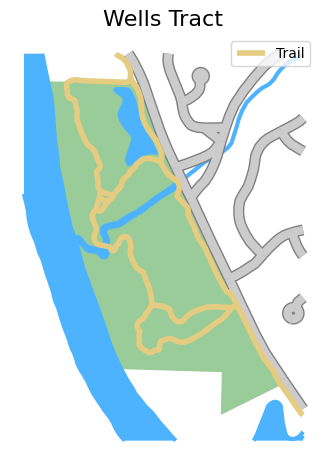

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


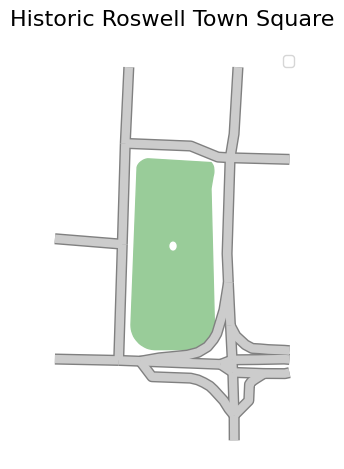

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


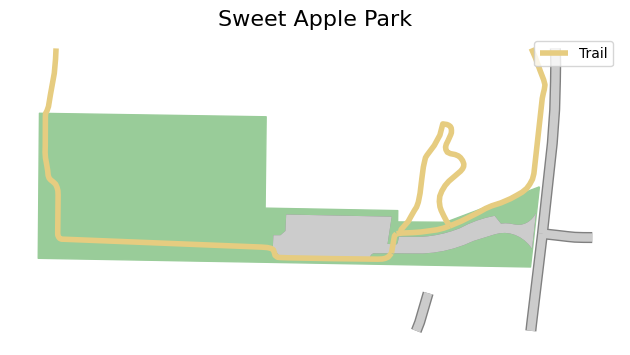

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


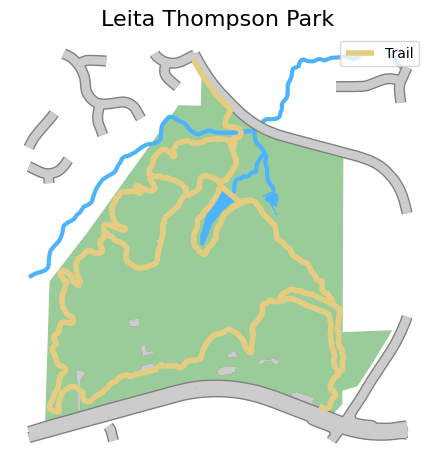

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


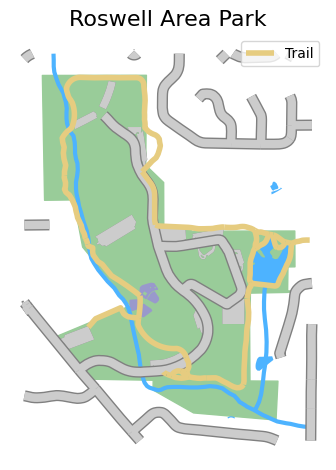

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


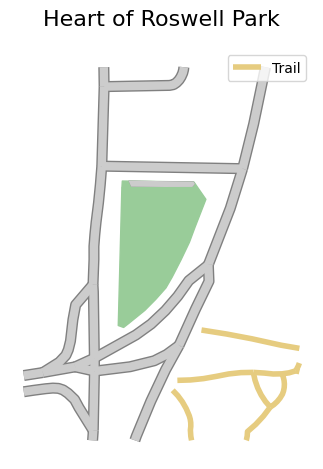

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


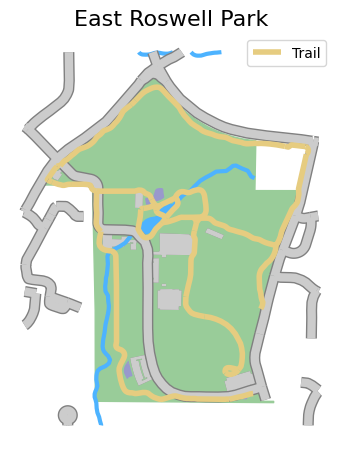

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


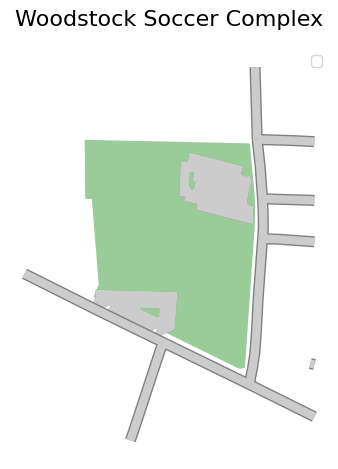

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


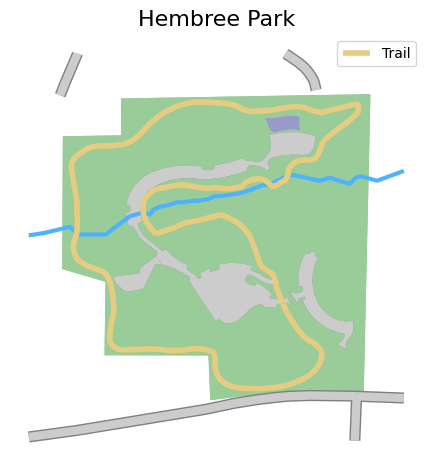

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


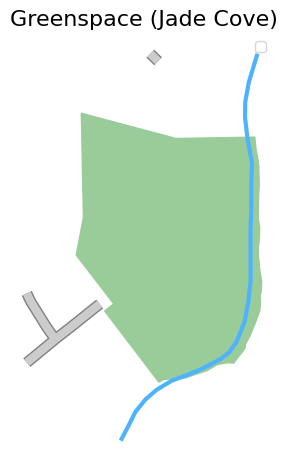

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


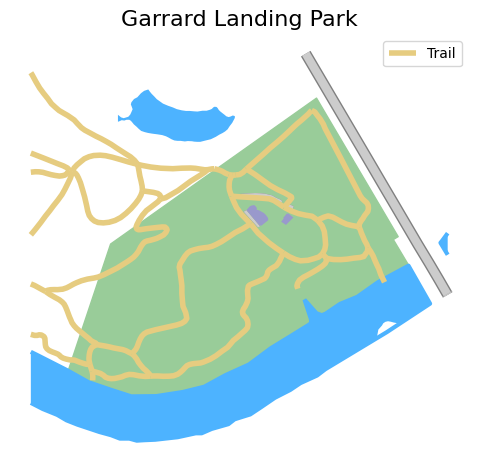

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


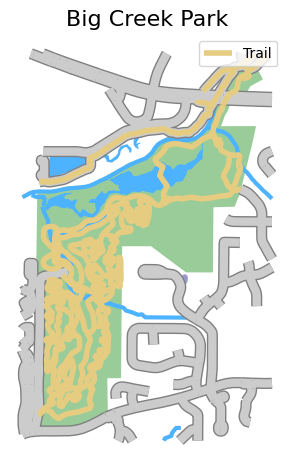

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


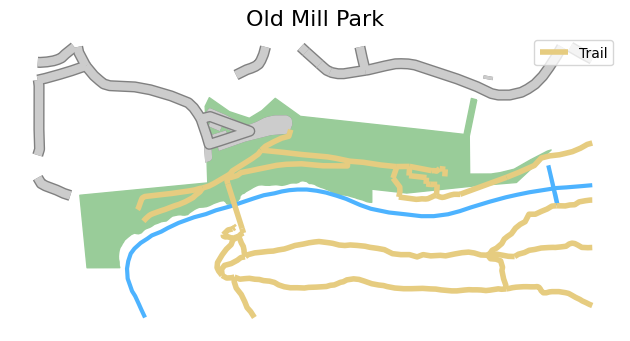

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


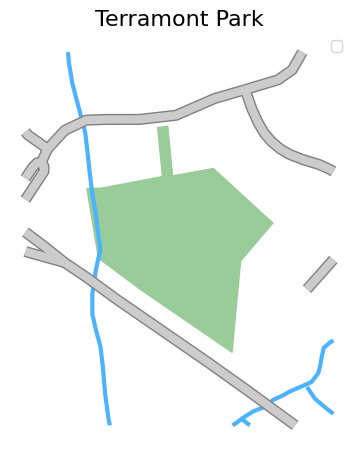

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


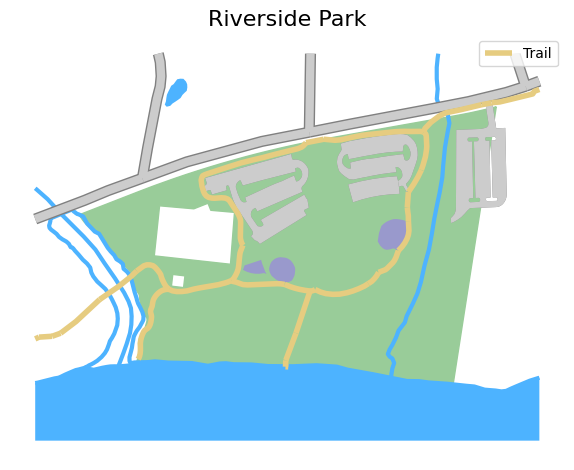

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


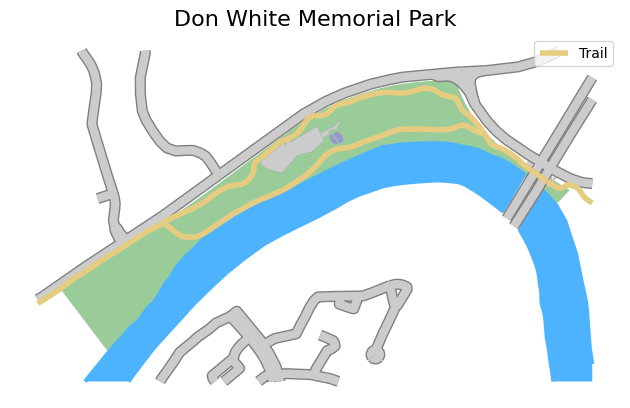

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


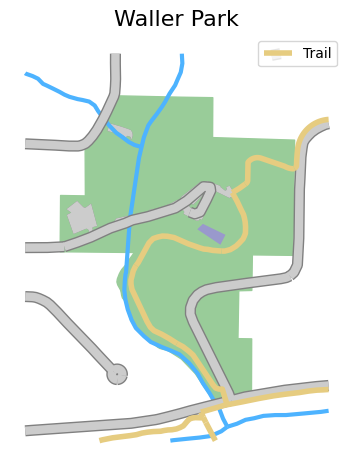

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


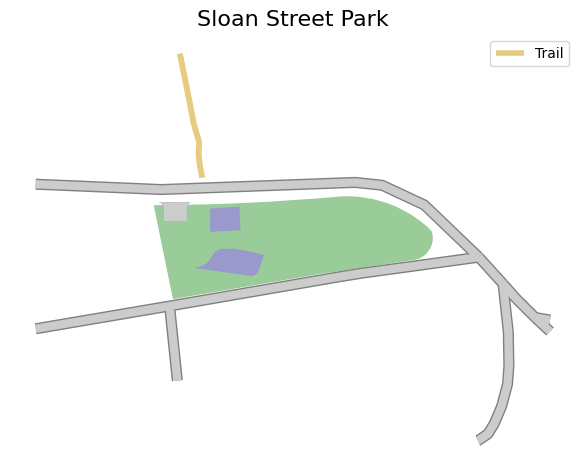

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


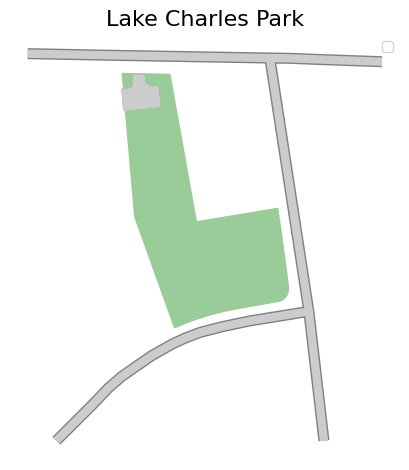

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


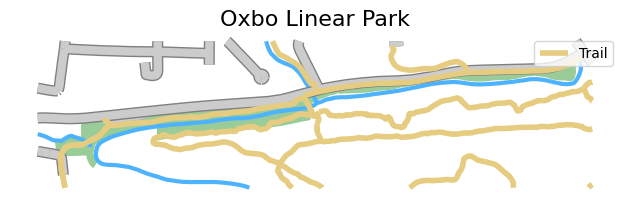

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


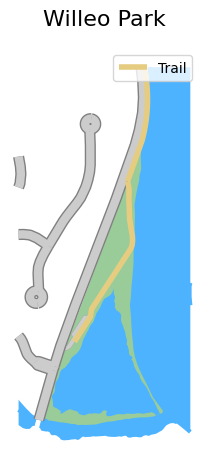

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


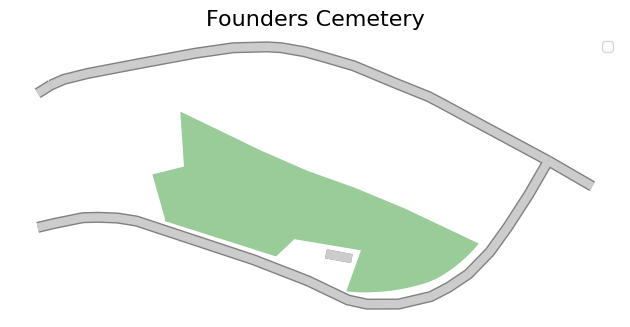

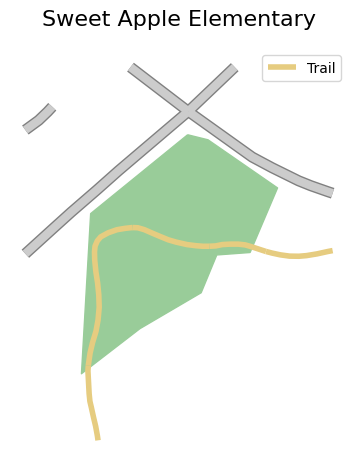

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


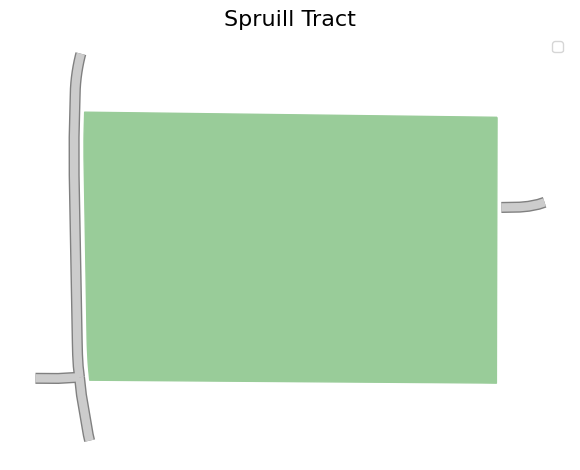

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


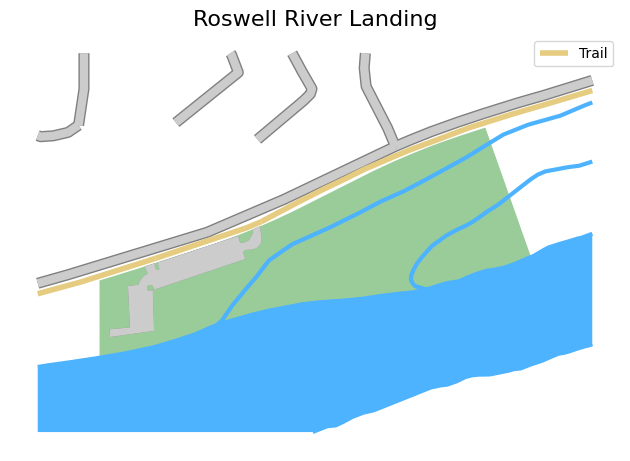

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


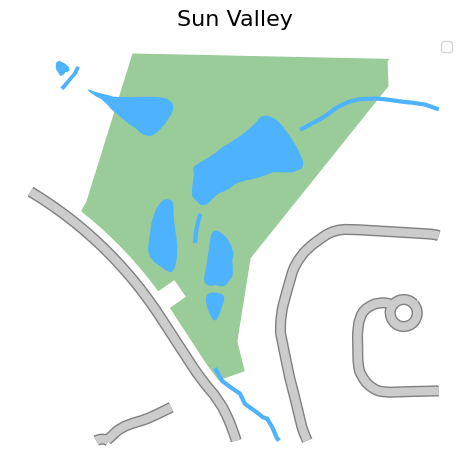

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


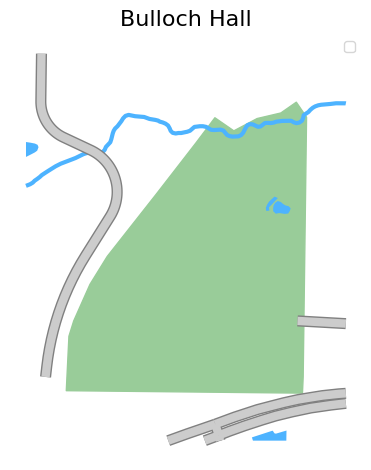

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


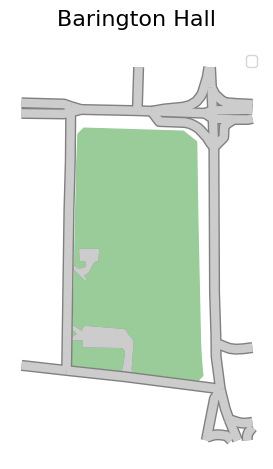

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


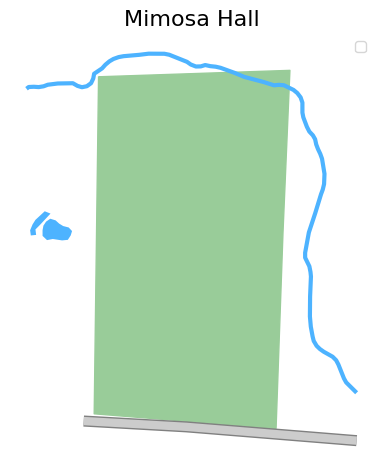

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


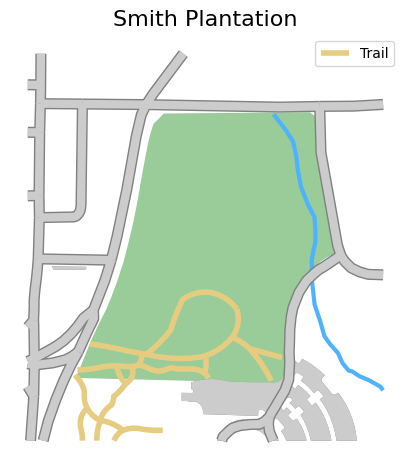

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


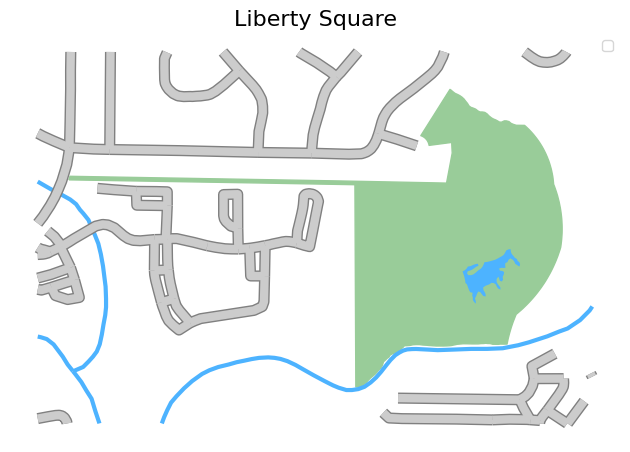

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


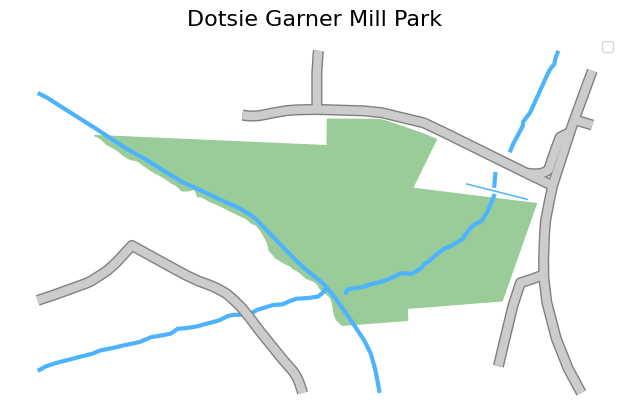

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


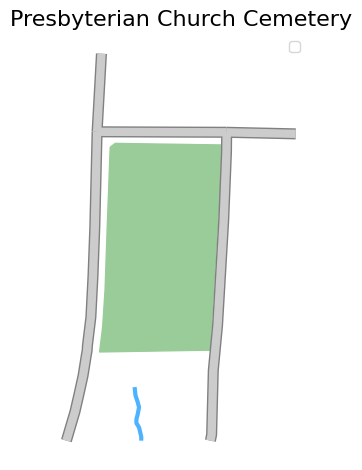

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


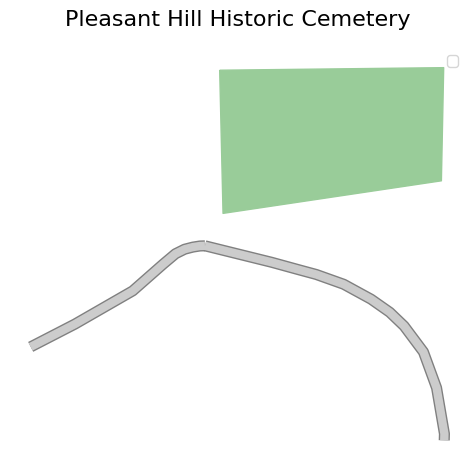

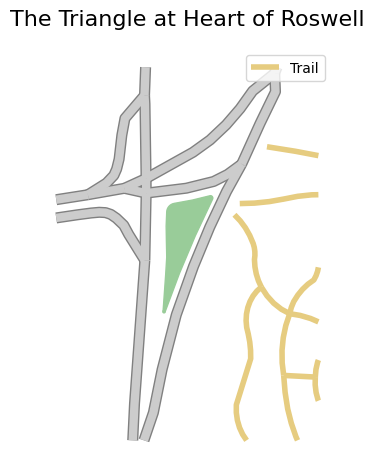

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


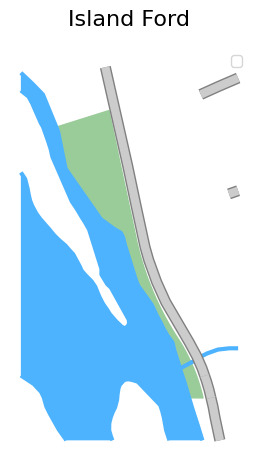

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


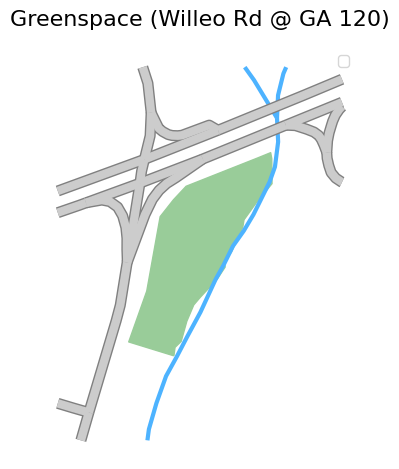

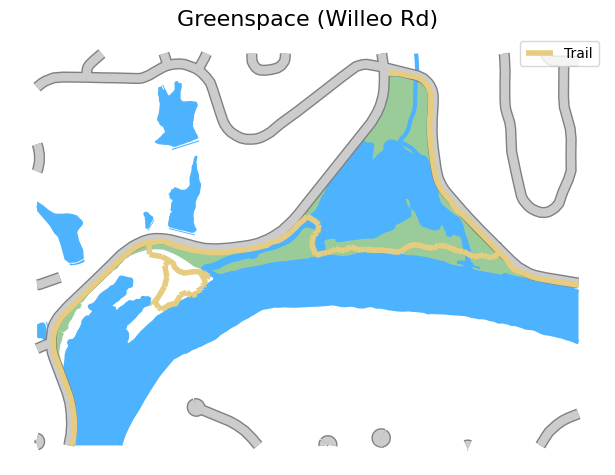

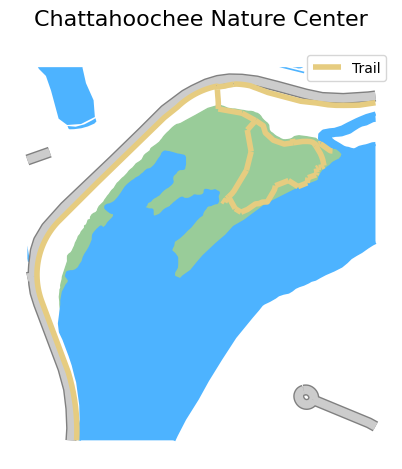

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


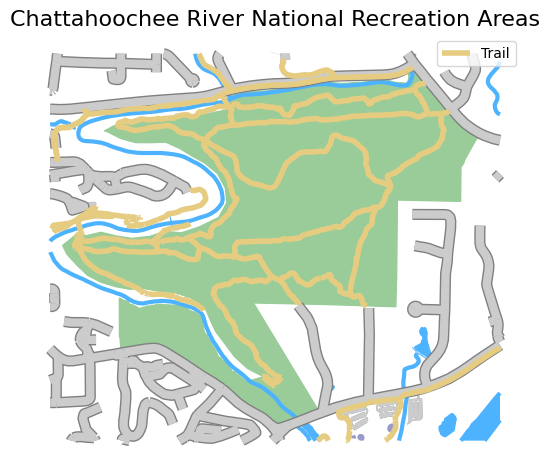

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


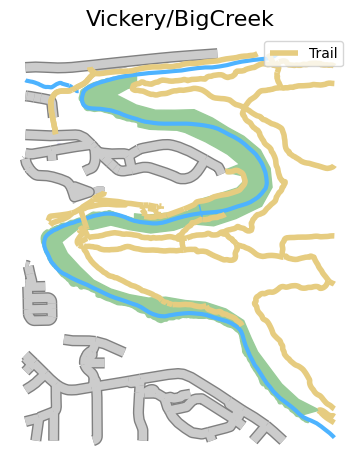

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


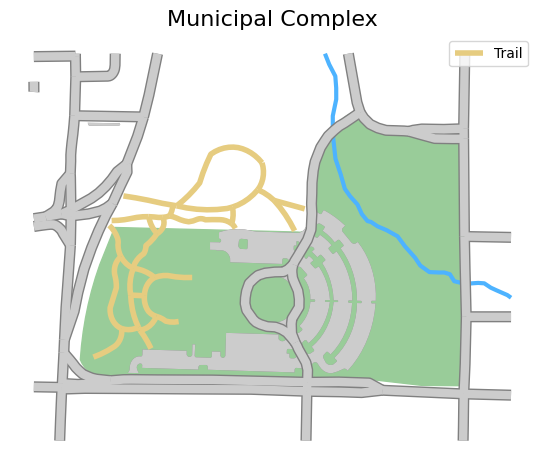

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


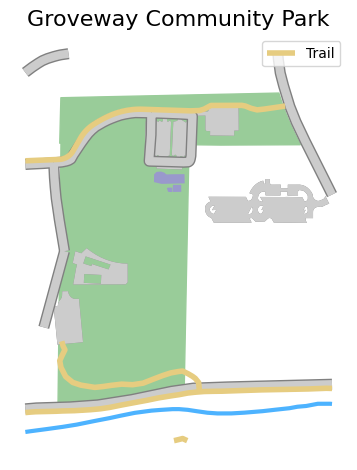

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


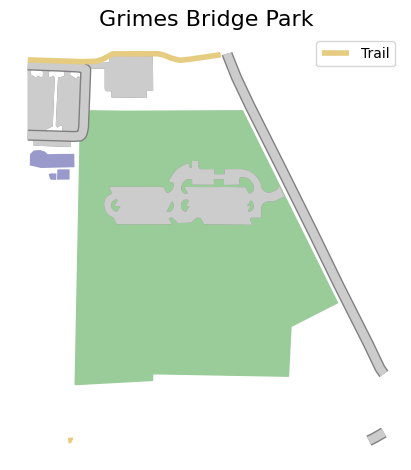

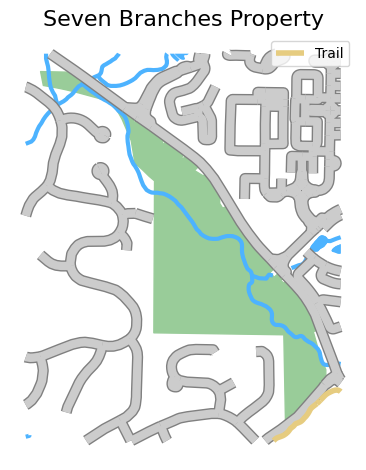

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


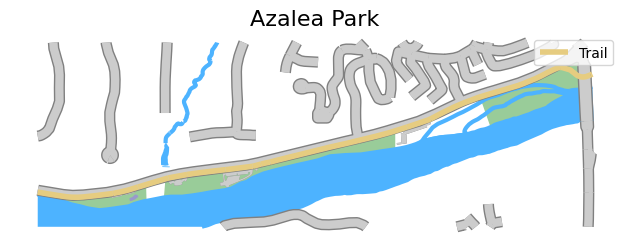

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


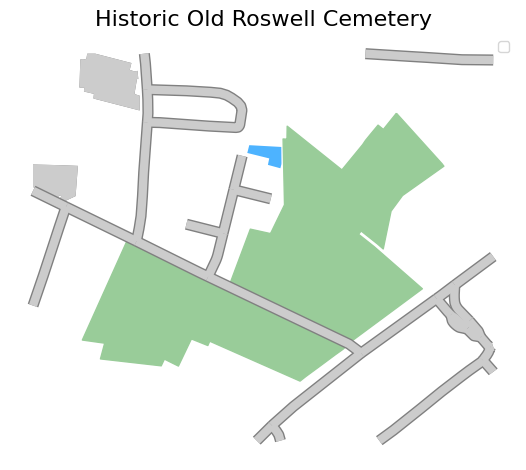

/var/folders/lr/v7klkd8j671bd11k9l_nvwcm0000gn/T/ipykernel_12059/3775887220.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes.legend( loc = 'best' )


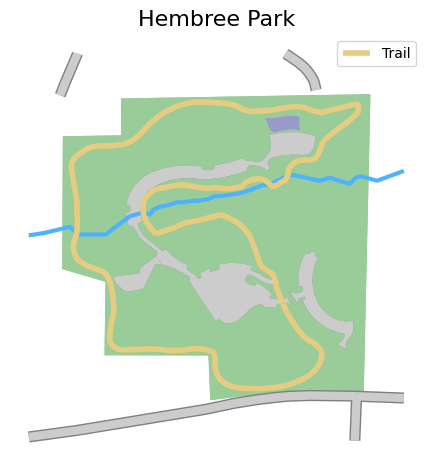

In [238]:
roads = get_geodf( 'road' )
water = get_geodf( 'water' )
streams = get_geodf( 'streams' )
parking = get_geodf( 'park', 'Parking Lots' )
playgrounds = get_geodf( 'park', 'Playground Area' )

roads = roads.dissolve( by = 'FULLNAME' ).explode()

trails = get_geodf( 'park', 'Trails' )

plot_order = [
    ( water, { 'color': ( 0.3, 0.7, 1.0 ) } ),
    ( streams, { 'color': ( 0.3, 0.7, 1.0 ) } ),
    ( parking, { 'color': ( 0.5, 0.5, 0.5 ), 'linewidth': 4 } ),
    ( parking, { 'color': ( 0.8, 0.8, 0.8 ), 'linewidth': 2, 'label': 'Parking' } ),
    ( roads, { 'color': ( 0.5, 0.5, 0.5 ), 'linewidth': 8 } ),
    ( roads, { 'color': ( 0.8, 0.8, 0.8 ), 'linewidth': 6 } ),
    ( playgrounds, { 'color': ( 0.6, 0.6, 0.8 ), 'label': 'Playground' } ),
    ( trails, { 'color': ( 0.9, 0.8, 0.5 ), 'label': 'Trail', 'linewidth': 4 } )
]

default_kwargs = {
    'linewidth': 3
}

for target in park_bounds.Name:
    figure, axes = plot.subplots()
    
    mask = park_bounds.Name == target
    clip_box = expand_clip_box( list( park_bounds[mask].bounds.iloc[0] ) )
    park_green = ( 0.6, 0.8, 0.6 )
    park_bounds[mask].plot( color = park_green, ax = axes, linewidth = 1, edgecolor = 'face' )

    for plot_layer in plot_order:
        layer = plot_layer[0].clip( clip_box )
        if len( layer ) < 1:
            continue
        
        kwargs = default_kwargs.copy()
        kwargs.update( **plot_layer[1] )
        H = layer.plot( ax = axes, **kwargs )

    axes.axis( 'off' )
    axes.legend( loc = 'best' )
    axes.set_title( target, fontsize = 16 )

    plot.tight_layout()
    plot.show()

In [195]:
library.library

,label,_filename,layer,ix
0,road,./data/data-00007,NaN,NaN
1,water,./data/data-00008,NaN,NaN
2,streams,./data/data-00009,NaN,NaN
3,park,./data/data-00010,Water Fountains,0
4,park,./data/data-00011,Trees,1
5,park,./data/data-00012,Trash Containers,2
6,park,./data/data-00013,Trail Counters,3
7,park,./data/data-00014,Signs,4
8,park,./data/data-00015,Shade Structures,5
9,park,./data/data-00016,Portalets,6


In [134]:
centerline_gp.geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [159]:
centerline_url = 'https://gisweb.ci.roswell.ga.us/arcgis/rest/services/LGIM_Viewer/StreetSpeedLimits/MapServer/0/query?where=1%3D1&text=&objectIds=&time=&timeRelation=esriTimeRelationOverlaps&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&havingClause=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&returnExtentOnly=false&sqlFormat=none&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=geojson'
centerline_geojson = fetch_geojson( f'{url_road_data}?where=1%3D1&timeRelation=esriTimeRelationOverlaps&geometryType=esriGeometryEnvelope&spatialRel=esriSpatialRelIntersects&units=esriSRUnit_Foot&returnGeometry=true&returnTrueCurves=false&returnIdsOnly=false&returnCountOnly=false&returnZ=false&returnM=false&returnDistinctValues=false&returnExtentOnly=false&sqlFormat=none&featureEncoding=esriDefault&f=geojson&resultOffset=4000', append_query = False )

In [160]:
centerline_gp = geopandas.read_file( centerline_geojson )